In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split

X, y = datasets.make_classification(n_samples=50000, n_features=20,
                                    n_informative=2, n_redundant=5,
                                    random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=500, random_state=0)

/Users/thanhbinhle/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Probability reliability plots

In [3]:
from sklearn.calibration import calibration_curve


def plot_calibration(classifiers, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    colors = plt.cm.rainbow(np.linspace(0, 1, len(classifiers)))
    for (name, clf), c in zip(classifiers, colors):
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % name, c=c)

        x = np.linspace(0, 1, 500)
        smoothed_prob_pos = gaussian_kde(prob_pos)(x)
        ax2.plot(x, smoothed_prob_pos, c=c)
        ax2.fill_between(x, 0, smoothed_prob_pos, alpha=0.1, facecolor=c)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("# samples")

    plt.tight_layout()

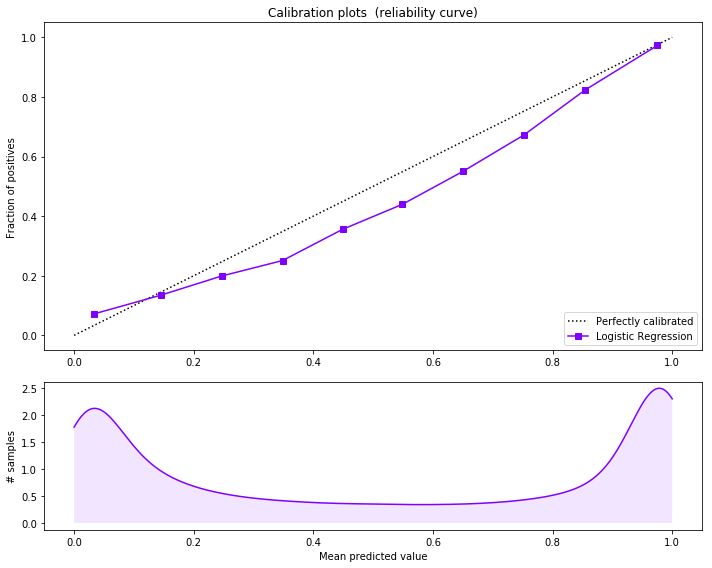

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
plot_calibration([('Logistic Regression', lr)])

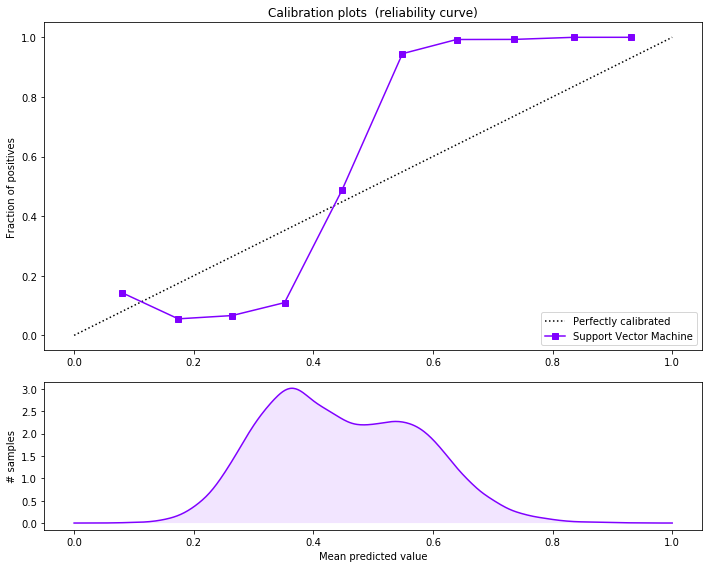

In [5]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=1.0)
plot_calibration([('Support Vector Machine', svc)])

In [6]:
from sklearn.cross_validation import cross_val_score

print("Logistic Regression: %0.3f" %
      cross_val_score(lr, X_train, y_train, cv=5).mean())
print("Linear SVC: %0.3f" %
      cross_val_score(svc, X_train, y_train, cv=5).mean())

Logistic Regression: 0.878
Linear SVC: 0.876


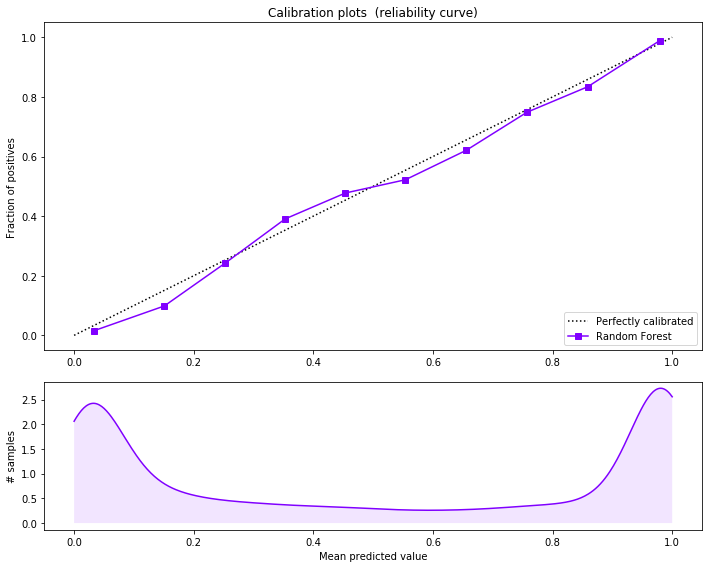

In [7]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100)
plot_calibration([('Random Forest', rf)])

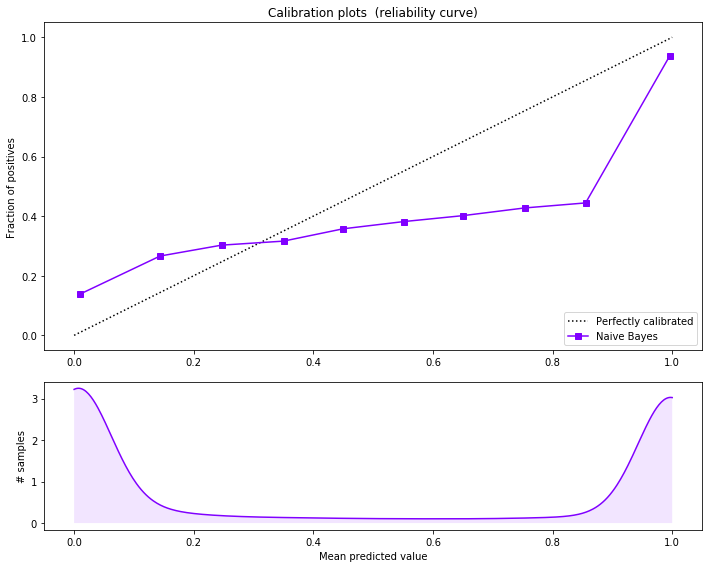

In [8]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
plot_calibration([('Naive Bayes', gnb)])

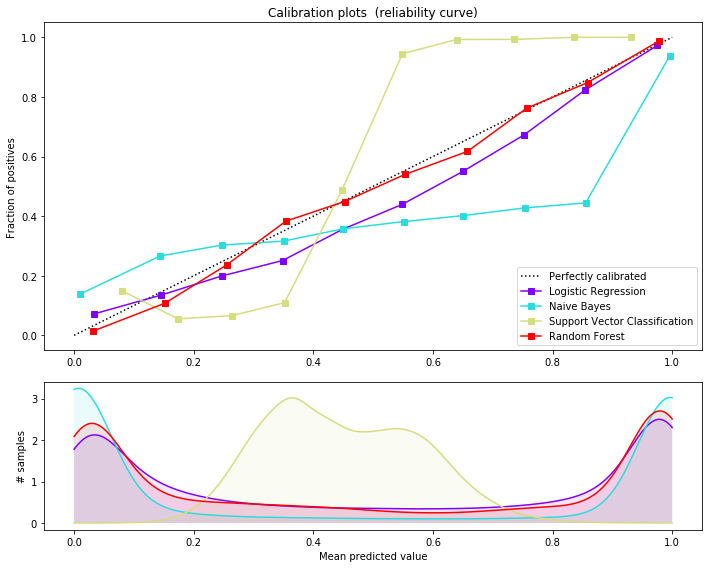

In [9]:
classifiers =  [
    ('Logistic Regression', lr),
    ('Naive Bayes', gnb),
    ('Support Vector Classification', svc),
    ('Random Forest', rf),
]

plot_calibration(classifiers)

## Calibration

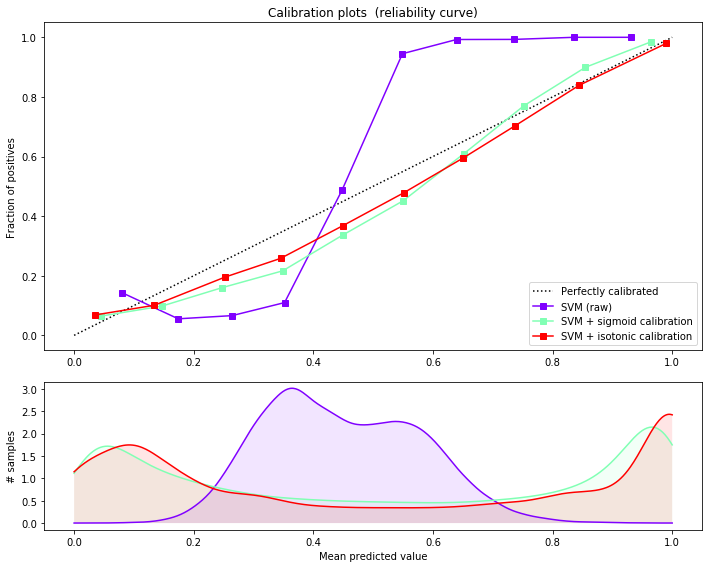

In [10]:
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC(C=1.0)
sigmoid_svc = CalibratedClassifierCV(svc, method='sigmoid')
isotonic_svc = CalibratedClassifierCV(svc, method='isotonic')
svc_models = [
    ('SVM (raw)', svc),
    ('SVM + sigmoid calibration', sigmoid_svc),
    ('SVM + isotonic calibration', isotonic_svc),
]
plot_calibration(svc_models)

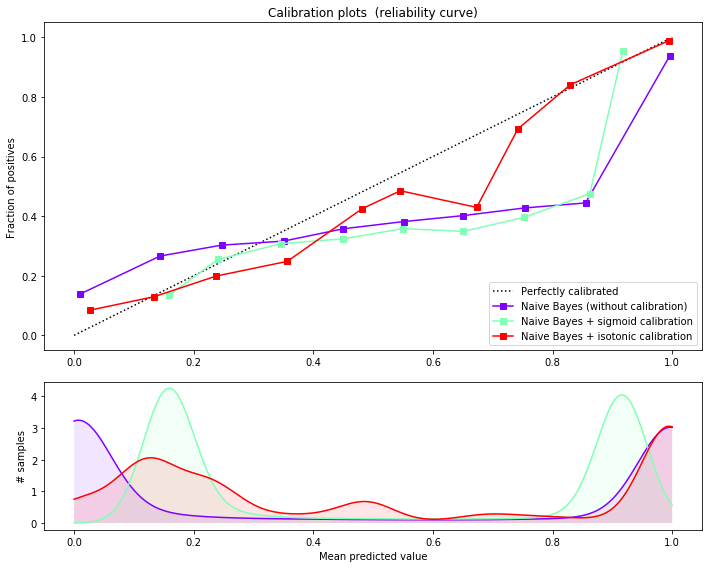

In [11]:
gnb = GaussianNB()
sigmoid_gnb = CalibratedClassifierCV(gnb, method='sigmoid')
isotonic_gnb = CalibratedClassifierCV(gnb, method='isotonic')
gnb_models = [
    ('Naive Bayes (without calibration)', gnb),
    ('Naive Bayes + sigmoid calibration', sigmoid_gnb),
    ('Naive Bayes + isotonic calibration', isotonic_gnb),
]
plot_calibration(gnb_models)

In [12]:
from sklearn.metrics import log_loss, brier_score_loss

for name, model in gnb_models:
    prob_pos = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    bs = brier_score_loss(y_test,prob_pos)
    ll = log_loss(y_test, prob_pos)
    print("%s:\tBrier score = %0.3f, log loss = %0.3f"
          % (name, bs, ll))

Naive Bayes (without calibration):	Brier score = 0.118, log loss = 0.637
Naive Bayes + sigmoid calibration:	Brier score = 0.111, log loss = 0.371
Naive Bayes + isotonic calibration:	Brier score = 0.100, log loss = 0.439
